In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
!pip install catboost
import catboost
from catboost import CatBoostClassifier
import gensim
import nltk
!pip install optuna
import optuna
import gensim.downloader

# Скачивание данных и преобразование текстов

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/mfk_ton/texts.csv')
with open('/content/drive/MyDrive/mfk_ton/train.labels') as f:
    y = f.readlines()
with open('/content/drive/MyDrive/mfk_ton/train.texts') as X:
    lines = X.readlines()
data = pd.DataFrame({'text' : lines, 'y' : y})
data['y'] = data['y'].apply(lambda x: 'pos' if x == 'pos\n' else 'neg')

**Убираю различный шум в данных: ссылки, числа, слеши и тд**

In [ ]:
for i in range(len(data['text'])):

    data['text'][i] = re.sub(r"(@[A-Za-z0-9]+)", "", data['text'][i])

    data['text'][i] = re.sub(r"[^0-9A-Za-z \t]", "", data['text'][i])

    data['text'][i] = re.sub(r"\w+:\/\/\S+", "", data['text'][i])

    data['text'][i] = re.sub(r"^rt", "", data['text'][i], flags=re.IGNORECASE)

    data['text'][i] = re.sub(r"http.+", "", data['text'][i], flags=re.IGNORECASE)

In [ ]:
for i in range(len(test['texts'])):

    test['texts'][i] = re.sub(r"(@[A-Za-z0-9]+)", "", test['texts'][i])

    test['texts'][i] = re.sub(r"[^0-9A-Za-z \t]", "", test['texts'][i])

    test['texts'][i] = re.sub(r"\w+:\/\/\S+", "", test['texts'][i])

    test['texts'][i] = re.sub(r"^rt", "", test['texts'][i], flags=re.IGNORECASE)

    test['texts'][i] = re.sub(r"http.+", "", test['texts'][i], flags=re.IGNORECASE)

In [ ]:
X = pd.DataFrame(data['text'])
y = data['y']

X_test = pd.DataFrame(test['texts'])
X_test = X_test.rename(columns = {'texts' : 'text'})

In [ ]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stopwords.words('english')[:5]

['i', 'me', 'my', 'myself', 'we']

Привожу слова к нижнему регистру и убираю stopwords

In [ ]:
import nltk
from tqdm import tqdm
text_clean = []
for i in tqdm(range(len(test.texts))):
    char_clean = []
    for char in str(test['texts'][i]).split():
        char = char.lower()
        if char not in stopwords.words('english'):
            char_clean.append(char)
        else:
            continue
    char_clean = ' '.join(char_clean)
    text_clean.append(char_clean)
test['texts'] = text_clean

100%|██████████| 10000/10000 [05:10<00:00, 32.23it/s]


In [ ]:
import nltk
from tqdm import tqdm
text_clean = []
for i in tqdm(range(len(data.text))):
    char_clean = []
    for char in str(data['text'][i]).split():
        char = char.lower()
        if char not in stopwords.words('english'):
            char_clean.append(char)
        else:
            continue
    char_clean = ' '.join(char_clean)
    text_clean.append(char_clean)
data['text'] = text_clean

100%|██████████| 15000/15000 [07:47<00:00, 32.07it/s]


# Валидация с оптюной



In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.1)

    param = {
        'iterations' : trial.suggest_int("iterations", 100, 1500),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 7),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
    }


    cb = CatBoostClassifier(**param, text_features = ['text'])

    cb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(valid_x)
    accuracy = accuracy_score(valid_y, preds)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800)
trial = study.best_trial

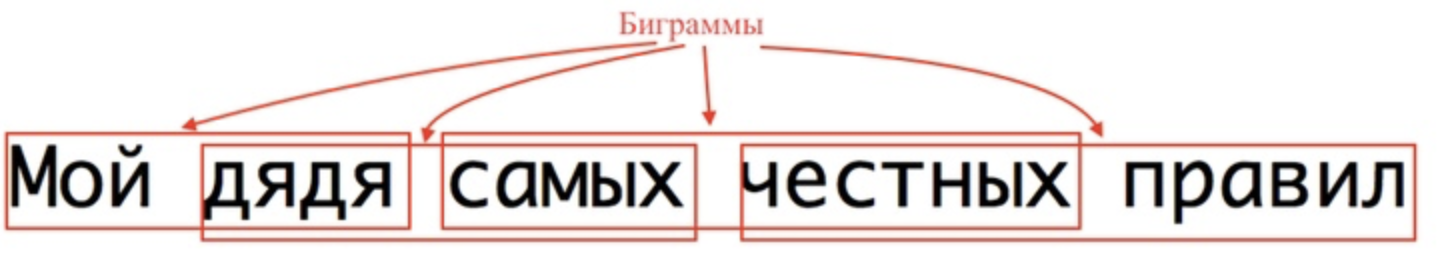

In [ ]:
cb = CatBoostClassifier(**trial.params, text_features = ['text'], verbose = 0)

In [ ]:
cb.fit(X, y)

In [ ]:
cb.get_all_params()['text_processing']

{'dictionaries': [{'start_token_id': '0',
   'occurrence_lower_bound': '5',
   'skip_step': '0',
   'end_of_word_token_policy': 'Insert',
   'token_level_type': 'Word',
   'end_of_sentence_token_policy': 'Skip',
   'gram_order': '2',
   'max_dictionary_size': '50000',
   'dictionary_id': 'BiGram'},
  {'start_token_id': '0',
   'occurrence_lower_bound': '5',
   'skip_step': '0',
   'end_of_word_token_policy': 'Insert',
   'token_level_type': 'Word',
   'end_of_sentence_token_policy': 'Skip',
   'gram_order': '1',
   'max_dictionary_size': '50000',
   'dictionary_id': 'Word'}],
 'feature_processing': {'default': [{'dictionaries_names': ['BiGram', 'Word'],
    'feature_calcers': ['BoW'],
    'tokenizers_names': ['Space']},
   {'dictionaries_names': ['Word'],
    'feature_calcers': ['NaiveBayes'],
    'tokenizers_names': ['Space']}]},
 'tokenizers': [{'number_token': '🔢',
   'skip_empty': '1',
   'number_process_policy': 'LeaveAsIs',
   'tokenizer_id': 'Space',
   'token_types': ['Number',

In [ ]:
pred = cb.predict(X_test)
test['labels'] = pred
test[['id', 'labels']].to_csv('y_pred.csv', index = False)

Качество на тесте 0.88

# Сatboost + word2vec

In [ ]:
vec = gensim.downloader.load('glove-twitter-25')

df = pd.DataFrame(columns = [x for x in range(25)])

from tqdm import tqdm
for i in tqdm(range(len(data))):
   words = data['text'].iloc[i]
   super_vect = np.zeros(25)
   for word in words:
    if word in vec and word:
      sup = vec[word]
      super_vect = super_vect + sup
   df = pd.concat([df, pd.DataFrame(super_vect).T])

[==================================================] 100.0% 104.8/104.8MB downloaded


100%|██████████| 15000/15000 [01:02<00:00, 240.02it/s]


In [ ]:
df_test = pd.DataFrame(columns = [x for x in range(25)])

for i in tqdm(range(len(test))):
   words = test['texts'].iloc[i]
   super_vect = np.zeros(25)
   for word in words:
    if word in vec and word:
      sup = vec[word]
      super_vect = super_vect + sup
   df_test = pd.concat([df_test, pd.DataFrame(super_vect).T])

100%|██████████| 10000/10000 [00:40<00:00, 249.71it/s]


In [ ]:
cb = CatBoostClassifier(verbose = 0)
cb.fit(df, y)

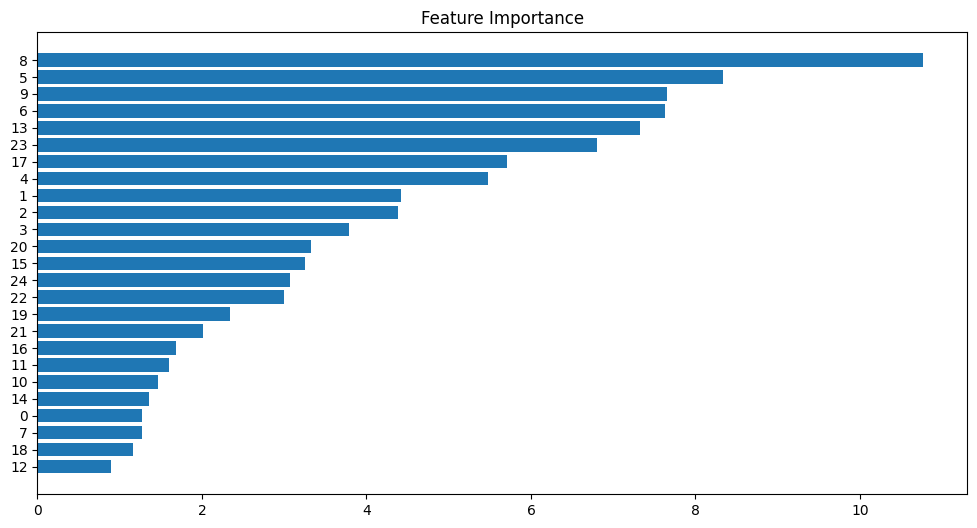

In [ ]:
feature_importance = cb.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df.columns)[sorted_idx])
plt.title('Feature Importance');

In [ ]:
df = df[np.array(df.columns)[sorted_idx][0:10]]
df_test = df_test[np.array(df.columns)[sorted_idx][0:10]]

In [ ]:
df.index = [x for x in range(15000)]
df_test.index = [x for x in range(10000)]

In [ ]:
X_conc = X.join(df)
X_conc_test = X_test.join(df_test)

In [ ]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(X,y, test_size=0.1)

    param = {
        'iterations' : trial.suggest_int("iterations", 100, 1500),
        'learning_rate':trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        'depth':trial.suggest_int("depth", 4, 7),
        'bagging_temperature':trial.suggest_float("bagging_temperature", 0.0, 10.0),
    }


    cb = CatBoostClassifier(**param, text_features = ['text'])

    cb.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], verbose=0, early_stopping_rounds=100)

    preds = cb.predict(valid_x)
    accuracy = accuracy_score(valid_y, preds)
    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, timeout=1800)
trial = study.best_trial

In [ ]:
model = CatBoostClassifier(**trial.params, text_features=['text'])

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y)

In [ ]:
model.fit(X_train, y_train, verbose = 0)

In [ ]:
pred = cb.predict(X_test)
test['labels'] = pred
test[['id', 'labels']].to_csv('y_pred.csv', index = False)